# Clustering based on BYTES, PACKETS, DURATION

## Preparing a dataset

Load the dataset.

In [24]:
from cesnet_datazoo.datasets import CESNET_QUIC22

dataset = CESNET_QUIC22(data_root="data/CESNET_QUIC22/", size="XS", silent=True)

Prepare the dataset with config and check its columns.

In [25]:
from cesnet_datazoo.config import DatasetConfig

dataset_config = DatasetConfig(
    dataset=dataset,
    train_period_name="W-2022-44",
    train_size=100_000,
    use_packet_histograms=True,
)
dataset.set_dataset_config_and_initialize(dataset_config)

data_df = dataset.get_train_df()
data_df.columns

Index(['PPI', 'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION',
       'PPI_LEN', 'PPI_ROUNDTRIPS', 'PPI_DURATION', 'FLOW_ENDREASON_IDLE',
       'FLOW_ENDREASON_ACTIVE', 'FLOW_ENDREASON_OTHER', 'PSIZE_BIN1',
       'PSIZE_BIN2', 'PSIZE_BIN3', 'PSIZE_BIN4', 'PSIZE_BIN5', 'PSIZE_BIN6',
       'PSIZE_BIN7', 'PSIZE_BIN8', 'PSIZE_BIN1_REV', 'PSIZE_BIN2_REV',
       'PSIZE_BIN3_REV', 'PSIZE_BIN4_REV', 'PSIZE_BIN5_REV', 'PSIZE_BIN6_REV',
       'PSIZE_BIN7_REV', 'PSIZE_BIN8_REV', 'IPT_BIN1', 'IPT_BIN2', 'IPT_BIN3',
       'IPT_BIN4', 'IPT_BIN5', 'IPT_BIN6', 'IPT_BIN7', 'IPT_BIN8',
       'IPT_BIN1_REV', 'IPT_BIN2_REV', 'IPT_BIN3_REV', 'IPT_BIN4_REV',
       'IPT_BIN5_REV', 'IPT_BIN6_REV', 'IPT_BIN7_REV', 'IPT_BIN8_REV', 'APP'],
      dtype='object')

Add imports.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Prepare the dataset dataframe.
Convert APP column to APP_NAME.

In [27]:
data_df["APP_NAME"] = data_df["APP"].apply(lambda x: dataset._tables_app_enum.get(x, "Unknown"))

data_df["APP_NAME"].value_counts()

APP_NAME
bongacams                6830
cloudflare-cdnjs         6355
alza-identity            6323
flightradar24            6110
playradio                5551
                         ... 
google-authentication       9
instagram                   9
ebay-kleinanzeigen          9
google-autofill             8
uber                        7
Name: count, Length: 101, dtype: int64

Prepare function for saving renderings.

In [28]:
import os

APE_PICTURES_SAVED = True

plt.rcParams.update({'font.size': 26})

def save_fig_to_images_dir(fig, fig_name, images_dir=("images", "five_apps")):
    try:
        os.makedirs(os.path.join(*images_dir))
    except FileExistsError:
        pass
    
    try:
        fig.savefig(os.path.join(*images_dir, fig_name), dpi=300, bbox_inches='tight',
                    format='pdf', transparent=True, pad_inches=0.1)
        print(f"Figure {fig_name} saved successfully.")
    except Exception as e:
        print(f"Error saving figure {fig_name}: {e}")

## Feature extraction

Create new features.

In [29]:
data_df["BYTES_PER_PACKET"] = data_df["BYTES"] / data_df["PACKETS"]
data_df["BYTES_PER_PACKET_REV"] = data_df["BYTES_REV"] / data_df["PACKETS_REV"]

Get only the columns that are needed for clustering.

In [30]:
features_to_extract = ["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION", "PPI_LEN", "PPI_ROUNDTRIPS", "PPI_DURATION",
                       "BYTES_PER_PACKET", "BYTES_PER_PACKET_REV"]

features_array = data_df[features_to_extract].to_numpy()
app_array = data_df[["APP"]].to_numpy().reshape(-1)

## Preprocessing

Standardize the features.

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

preprocessed_array = preprocessing_pipeline.fit_transform(features_array)

## Application choice

### Functions

In [32]:
from numpy.linalg import inv, det

def bhattacharyya_distance(mean1, cov1, mean2, cov2):
    cov_avg = (cov1 + cov2) / 2
    mean_diff = mean1 - mean2
    term1 = 0.125 * np.dot(np.dot(mean_diff.T, inv(cov_avg)), mean_diff)
    term2 = 0.5 * np.log(det(cov_avg) / np.sqrt(det(cov1) * det(cov2)))
    return term1 + term2

def find_most_different_classes_statistical(X, y, num_classes=5):
    unique_classes = np.unique(y)
    class_stats = {}
    for cls in unique_classes:
        X_cls = X[y == cls]
        mean = X_cls.mean(axis=0)
        cov = np.cov(X_cls, rowvar=False) + 1e-6 * np.eye(X_cls.shape[1])
        class_stats[cls] = (mean, cov)

    classes = list(class_stats.keys())
    n = len(classes)

    # build distance matrix
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            mean1, cov1 = class_stats[classes[i]]
            mean2, cov2 = class_stats[classes[j]]
            dist = bhattacharyya_distance(mean1, cov1, mean2, cov2)
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    # pick the pair with maximum distance
    i, j = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)
    selected_indices = [i, j]
    remaining_indices = set(range(n)) - set(selected_indices)

    # iteratively add the class farthest from current set
    while len(selected_indices) < num_classes and remaining_indices:
        best_candidate = None
        best_min_dist = -1
        for idx in remaining_indices:
            min_dist = min(distance_matrix[idx, sel] for sel in selected_indices)
            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_candidate = idx
        selected_indices.append(best_candidate)
        remaining_indices.remove(best_candidate)

    return [classes[idx] for idx in selected_indices]

### Choice

In [33]:
top_apps = find_most_different_classes_statistical(preprocessed_array, app_array, num_classes=5)

list(map(lambda x: dataset._tables_app_enum.get(x, "Unknown"), top_apps))

['alza-webapi', 'mdpi', 'instagram', 'youtube', 'google-autofill']

In [34]:
only_top_apps_array = np.isin(app_array, top_apps)

filtered_app_array = app_array[only_top_apps_array]
filtered_preprocessed_array = preprocessed_array[only_top_apps_array]

## KMeans

### Clustering

Cluster the data using KMeans NUMBER_OF_MULTIPLIERS (11) times.

In [35]:
from sklearn.cluster import KMeans

NUMBER_OF_MULTIPLIERS = 11

number_of_clusters = np.unique(filtered_app_array).shape[0]

kmeans_partitions = []

for cluster_multiplier in range(1, NUMBER_OF_MULTIPLIERS+1):
    kmeans = KMeans(n_clusters=number_of_clusters * cluster_multiplier, random_state=42)
    kmeans.fit(filtered_preprocessed_array)
    kmeans_partitions.append(kmeans.labels_)

### Evaluation

Plot homogeneity (purity) score.

Figure kmeans_homogeneity.pdf saved successfully.


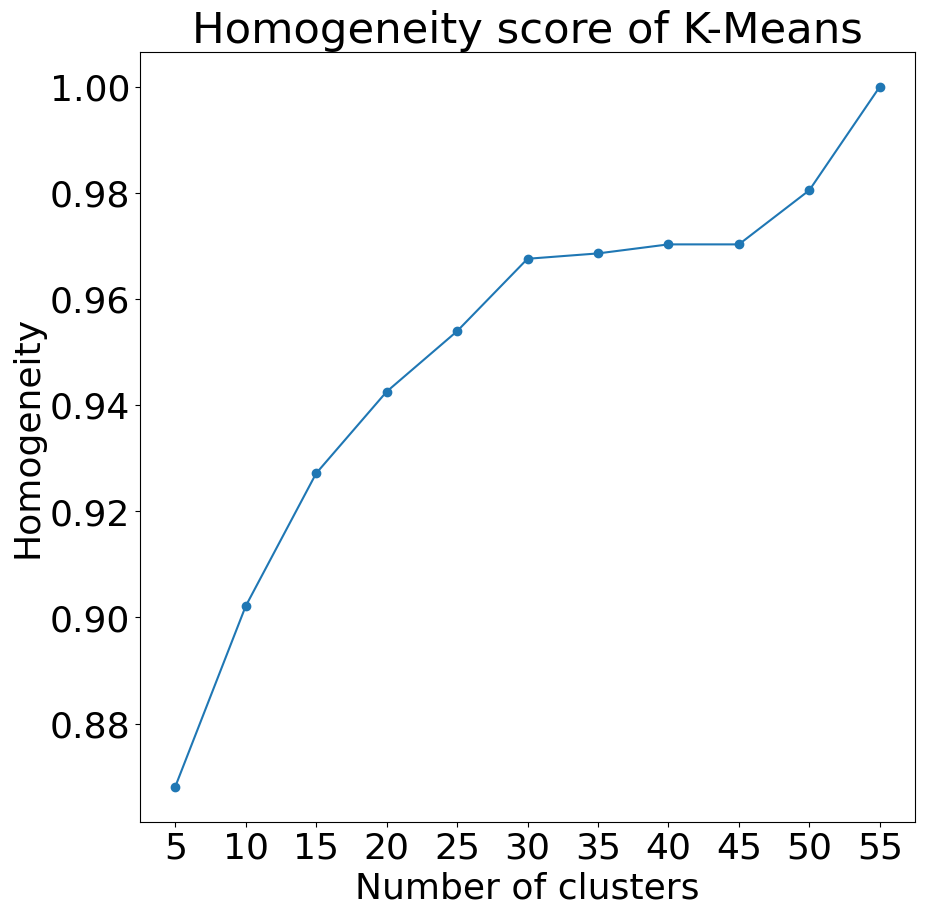

In [36]:
from sklearn.metrics.cluster import homogeneity_score

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters), 
        [homogeneity_score(filtered_app_array, kmeans) for kmeans in kmeans_partitions], 
        marker='o')
ax.set_title("Homogeneity score of K-Means")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Homogeneity")
ax.set_xticks(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters))

if APE_PICTURES_SAVED: save_fig_to_images_dir(fig, "kmeans_homogeneity.pdf")

Plot NMI score.

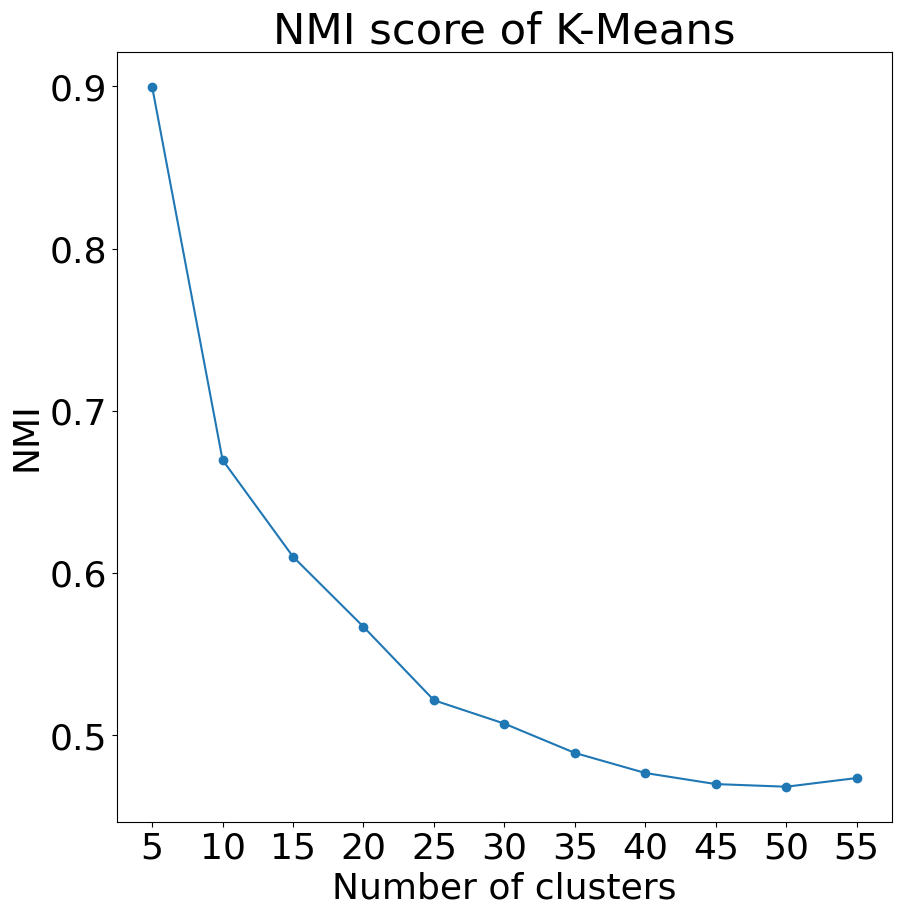

Figure kmeans_nmi.pdf saved successfully.


In [37]:
from sklearn.metrics.cluster import normalized_mutual_info_score

plt.rcParams.update({'font.size': 26})
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters), 
        [normalized_mutual_info_score(filtered_app_array, kmeans) for kmeans in kmeans_partitions], 
        marker='o')
ax.set_title("NMI score of K-Means")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("NMI")
ax.set_xticks(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters))
plt.show()

if APE_PICTURES_SAVED: save_fig_to_images_dir(fig, "kmeans_nmi.pdf")

Build a contingency matrix to evaluate the K-Means clustering (K = 5).

In [38]:
from sklearn.metrics.cluster import contingency_matrix

contingency_matrix(filtered_app_array, kmeans_partitions[0])

array([[  0, 199,   0,   1,   0],
       [  3,   4,   0,   1,   0],
       [  0,   2,   0,   0,   7],
       [  0,   0,  39,   0,   0],
       [  0,   0,   0,  45,   0]])

## HDBSCAN

### Clustering

Cluster the data using HDBSCAN.

In [39]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=7).fit(filtered_preprocessed_array)

### Evaluation

Check number of clusters.

In [40]:
np.unique(hdbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

Remove points that are marked as noise.

In [41]:
cleared_app_array = filtered_app_array[hdbscan.labels_ != -1]
cleared_hdbscan_labels = hdbscan.labels_[hdbscan.labels_ != -1]

f"HDBSCAN marked {hdbscan.labels_.shape[0] - cleared_hdbscan_labels.shape[0]} out of {hdbscan.labels_.shape[0]} packets as noise."

'HDBSCAN marked 65 out of 301 packets as noise.'

Show homogeneity (purity) score of HDBSCAN with noise and without noise.

In [42]:
homogeneity_score(filtered_app_array, hdbscan.labels_), homogeneity_score(cleared_app_array, cleared_hdbscan_labels)

(0.8460415716472369, 0.980405487050177)

Show NMI score of HDBSCAN with noise and without noise.

In [43]:
normalized_mutual_info_score(filtered_app_array, hdbscan.labels_), normalized_mutual_info_score(cleared_app_array, cleared_hdbscan_labels)

(0.517481328295092, 0.6065905164926988)

Build a contingency matrix for the HDBSCAN clustering.

In [44]:
from sklearn.metrics.cluster import contingency_matrix

contingency_matrix(filtered_app_array, hdbscan.labels_)

array([[53,  0,  0,  0, 15, 12, 38, 10,  9,  7, 19, 23, 14],
       [ 7,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  0,  0, 42,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

## Visualization

In [45]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_app_array = label_encoder.fit_transform(filtered_app_array)

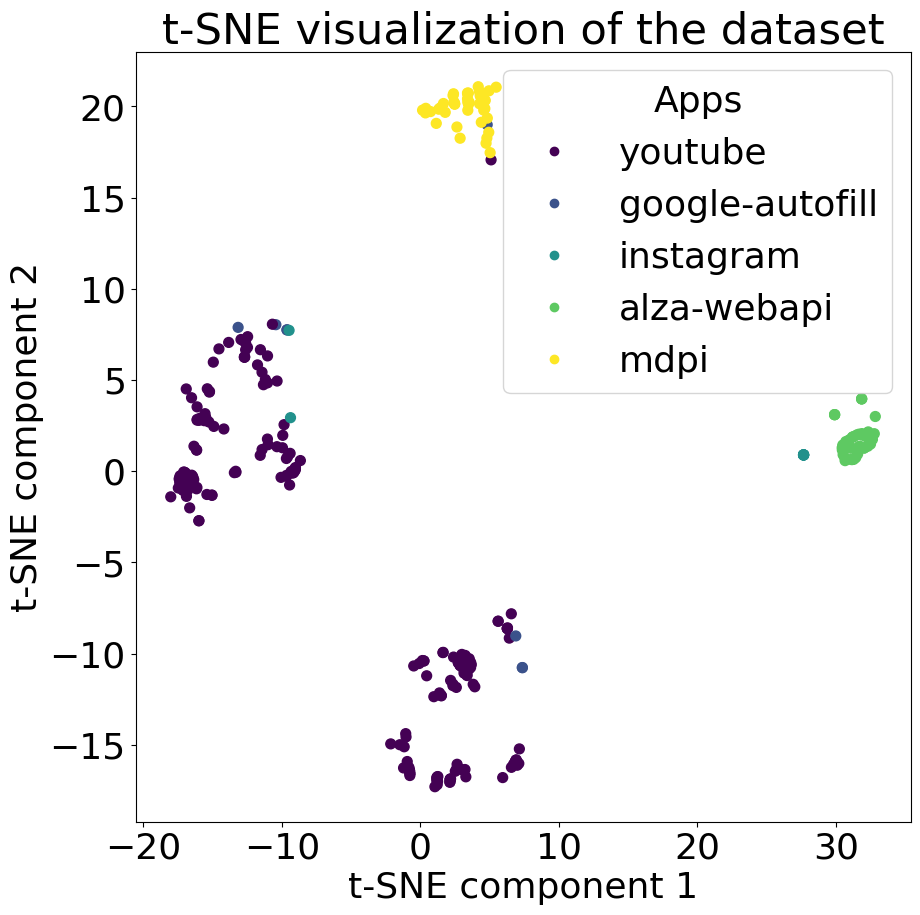

Figure true_labels.pdf saved successfully.


In [46]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_array = tsne.fit_transform(filtered_preprocessed_array)

fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(tsne_array[:, 0], tsne_array[:, 1], c=encoded_app_array, cmap='viridis', s=50)
ax.legend(scatter.legend_elements()[0], 
          list(map(lambda x: dataset._tables_app_enum.get(x, "Unknown"), sorted(top_apps))), 
          title="Apps")
ax.set_title("t-SNE visualization of the dataset")
ax.set_xlabel("t-SNE component 1")
ax.set_ylabel("t-SNE component 2")
plt.show()

if APE_PICTURES_SAVED: save_fig_to_images_dir(fig, "true_labels.pdf")